# Plot model fits for simulation analysis 2

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from cfr import framework
from cfr import figures
from cfr import task

res_dir = Path('/Users/morton/Dropbox/work/cmr_cfr/peers')
fit_dir = Path('/Users/morton/Dropbox/work/cmr_cfr/peers/fits/v5')

data_file = res_dir / 'peers_notask.csv'
patterns_file = res_dir / 'peers_patterns.hdf5'
figures.set_style()

## Read observed and simulated data

In [3]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [4]:
models = [
    'cmrs_fcf-loc-use',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_rec_use1',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_enc_use1-B_rec_use1',
]
model_names = [
    'DCMR',
    'DCMR-Restricted',
    'DCMR-Restricted2',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [5]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [6]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [7]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [8]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [9]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [17]:
data['item_index'] = fr.pool_index(data['item'], patterns['items'])

In [18]:
from psifr import transitions
import importlib
importlib.reload(fr)
importlib.reload(transitions)
drw = data.groupby('source').apply(
    fr.distance_rank_window, 
    'item_index', 
    1 - rsm, 
    np.array([-1, 0, 1]),
)

/Users/morton/PycharmProjects/psifr/src/psifr/measures.py:393: RuntimeWarning: Mean of empty slice
  stat = pd.DataFrame({'rank': np.nanmean(ranks, 0)}, index=index)


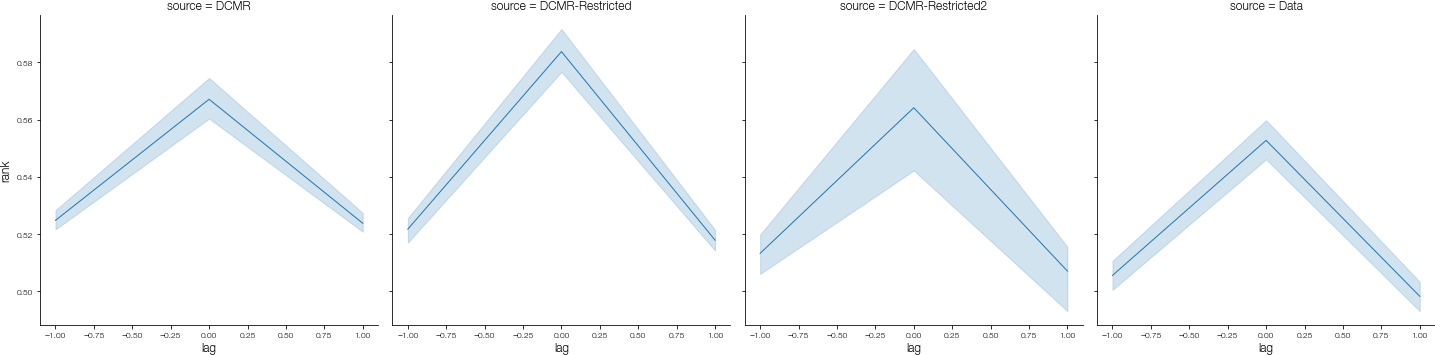

In [19]:
sns.relplot(data=drw, x="lag", y="rank", col="source", kind="line")

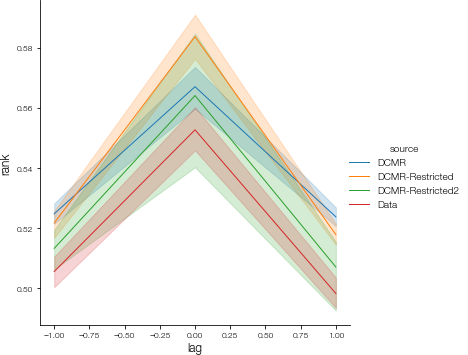

In [20]:
sns.relplot(data=drw, x="lag", y="rank", hue="source", kind="line")

In [23]:
lags = drw.unstack("lag").loc[:, "rank"]
diff = lags[-1] - lags[1]
p = diff.unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0, alternative='greater').iloc[0] for c in p.columns})

,DCMR,DCMR-Restricted,DCMR-Restricted2,Data
T,0.5787,1.964368,0.790573,2.100661
dof,68,68,74,125
alternative,greater,greater,greater,greater
p-val,0.282352,0.026788,0.21586,0.01884
CI95%,"[-0.0, inf]","[0.0, inf]","[-0.01, inf]","[0.0, inf]"
cohen-d,0.069667,0.236482,0.091288,0.187142
BF10,0.311,1.614,0.343,1.653
power,0.141883,0.617878,0.194482,0.67163


## Serial position effects

In [24]:
spc = data.groupby('source').apply(fr.spc)

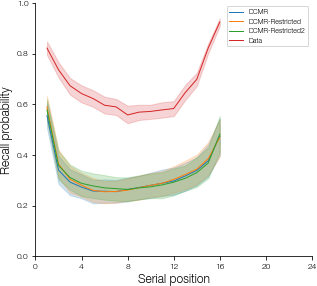

In [27]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.set(xticks=[0, 4, 8, 12, 16, 20, 24])
g.axes[0, 0].legend(fontsize='x-small')
#g.savefig(fig_dir / 'spc_comp.pdf')

In [28]:
pnr = data.groupby('source').apply(fr.pnr)

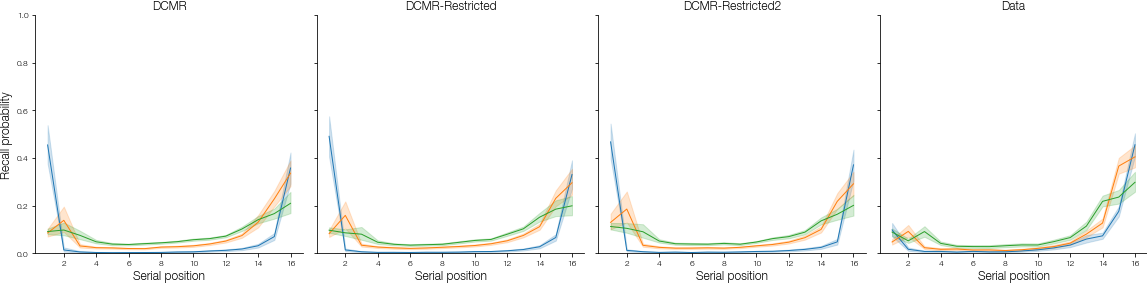

In [30]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='output', col='source', height=4, aspect=1
)
g.set_titles('{col_name}')
# g.savefig(fig_dir / 'pnr.pdf');

## Clustering measures

In [33]:
lag_rank_within = data.groupby('source').apply(fr.lag_rank)

/Users/morton/PycharmProjects/psifr/src/psifr/measures.py:238: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


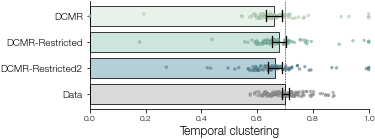

In [34]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [36]:
use_rank = data.groupby('source').apply(fr.distance_rank, 'item_index', 1 - rsm)

/Users/morton/PycharmProjects/psifr/src/psifr/measures.py:318: RuntimeWarning: Mean of empty slice
  {'subject': subject, 'rank': np.nanmean(ranks)}, index=[subject]


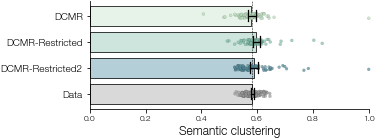

In [37]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    use_rank,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [39]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
)

/Users/morton/PycharmProjects/psifr/src/psifr/measures.py:352: RuntimeWarning: Mean of empty slice
  stat = pd.DataFrame({'rank': np.nanmean(ranks, 0)}, index=index)


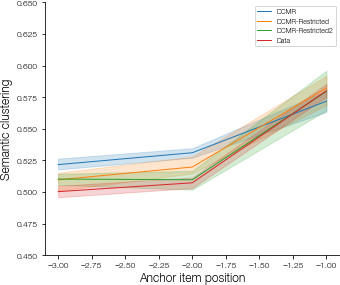

In [40]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
# g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [41]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.225321,250,two-sided,0.026952,"[0.0, 0.01]",0.280364,1.421,0.601349


In [42]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.256724,136,two-sided,0.001423,"[0.0, 0.02]",0.554462,20.662,0.898611


In [43]:
subs = dist_rank.loc['DCMR-Restricted']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.881993,136,two-sided,0.061974,"[-0.0, 0.02]",0.320412,0.91,0.463705


## Compound lag-CRP

In [44]:
crp = data.groupby('source').apply(fr.lag_crp_compound)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

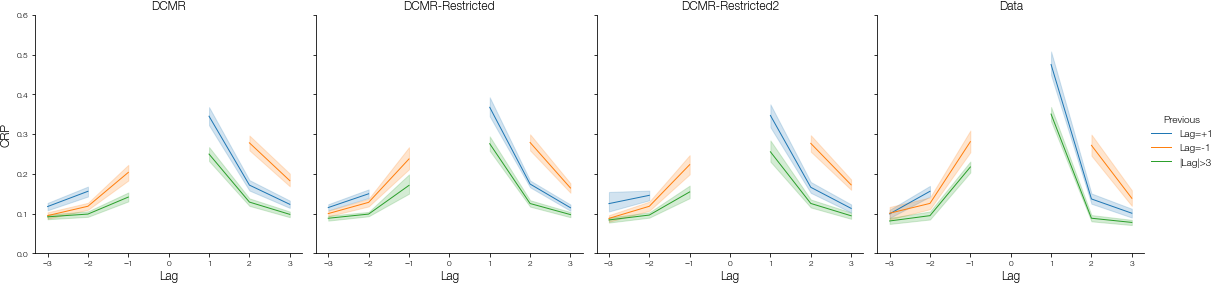

In [45]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
# g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [46]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.92118,125,two-sided,1.827842e-17,"[0.1, 0.15]",0.883849,3.079e+14,1.0


In [47]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.998669,125,two-sided,0.000002,"[0.04, 0.09]",0.445317,6970.418,0.99865


### Test for compound cuing in DCMR-Restricted

In [48]:
subs = summed.loc['DCMR-Restricted']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.448845,68,two-sided,2.073099e-22,"[0.08, 0.1]",1.739436,2.111e+19,1.0


In [49]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.084769,68,two-sided,3.864629e-15,"[0.05, 0.08]",1.214064,1.77e+12,1.0


In [50]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.13.0

cymr      : 0.11.2
pingouin  : 0.5.2
mindstorm : 0.9.0
cfr       : 0.1.0
pandas    : 1.2.3
seaborn   : 0.11.1
psifr     : 0.8.2
numpy     : 1.20.2
matplotlib: 3.5.2

